In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.7 MB/s eta 0:00:0000:01m0:01m
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

In [3]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# The main library for Neural ODEs
from torchdiffeq import odeint_adjoint as odeint

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda



# --- DATA PREPARATION (Common for both models) ---

In [5]:

# (Part A-b) Use a 2D toy dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data for better training performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


# --- PART A: Baseline - Simple Fully Connected Network ---


In [6]:


print("\n--- Part A: Training the Baseline Model ---")

# (a) Create and train a simple fully connected neural network with one hidden layer
class BaselineNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BaselineNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# --- Generic Training and Evaluation Functions ---

def calculate_accuracy(y_true, y_pred):
    predicted = torch.argmax(y_pred, dim=1)
    correct = (predicted == y_true).sum().item()
    return correct / len(y_true)

def train(model, optimizer, criterion, epochs=200):
    loss_history = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if (epoch + 1) % 50 == 0:
            acc = calculate_accuracy(y_train, outputs)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")
    return loss_history

# Initialize and train the baseline model
baseline_model = BaselineNet(input_dim=2, hidden_dim=32, output_dim=2).to(device)
optimizer_base = torch.optim.Adam(baseline_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train(baseline_model, optimizer_base, criterion)




--- Part A: Training the Baseline Model ---
Epoch [50/200], Loss: 0.2157, Accuracy: 0.9143
Epoch [100/200], Loss: 0.1077, Accuracy: 0.9686
Epoch [150/200], Loss: 0.0700, Accuracy: 0.9800
Epoch [200/200], Loss: 0.0563, Accuracy: 0.9800


[0.797825038433075,
 0.7294296622276306,
 0.6696659922599792,
 0.617429256439209,
 0.5716250538825989,
 0.5311787128448486,
 0.49537885189056396,
 0.46364349126815796,
 0.4354269504547119,
 0.41045424342155457,
 0.38837140798568726,
 0.36891525983810425,
 0.3518527150154114,
 0.33704787492752075,
 0.3243253827095032,
 0.3134984076023102,
 0.3043566644191742,
 0.2967301905155182,
 0.2903960645198822,
 0.2851785719394684,
 0.2808907628059387,
 0.2773497700691223,
 0.2743877172470093,
 0.27186235785484314,
 0.2696472108364105,
 0.2676016390323639,
 0.26568979024887085,
 0.263851135969162,
 0.26201969385147095,
 0.26015788316726685,
 0.258279949426651,
 0.25635892152786255,
 0.25441625714302063,
 0.2524809241294861,
 0.25052979588508606,
 0.24857211112976074,
 0.2465965449810028,
 0.24456852674484253,
 0.24247097969055176,
 0.2403070032596588,
 0.23805758357048035,
 0.2357254922389984,
 0.23331479728221893,
 0.2308439463376999,
 0.22833548486232758,
 0.22580289840698242,
 0.223263636231422

# --- PART B: Neural ODE Model ---

In [7]:


print("\n--- Part B: Training the Neural ODE Model ---")

# (a) Define the ODE function f(h, t) as a small neural network
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        # This network defines the derivative dh/dt
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
        )

    # The function must take (t, h) as input, a requirement for torchdiffeq
    def forward(self, t, h):
        return self.net(h)

# (a) Replace the hidden layer with a Neural ODE block
class NeuralODENet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralODENet, self).__init__()
        # The ODEFunc defines the dynamics
        self.ode_func = ODEFunc(hidden_dim)
        
        # We need layers to map from input to hidden dim and from hidden to output dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # (c) Define the time interval to integrate over
        self.time_span = torch.tensor([0.0, 1.0]).to(device)

    def forward(self, x):
        # 1. Map input to the initial hidden state h(0)
        h0 = self.input_layer(x)
        
        # 2. (b, c) Evolve the hidden state from t=0 to t=1 using the ODE solver
        # The `odeint` function handles both the forward integration and the
        # backward pass (gradient calculation) using the memory-efficient adjoint method.
        h_final = odeint(self.ode_func, h0, self.time_span)[-1] # We only need the final state at t=1
        
        # 3. Use the final hidden state for classification
        out = self.output_layer(h_final)
        return out



--- Part B: Training the Neural ODE Model ---


In [8]:
# (d) Train the model and compare
neural_ode_model = NeuralODENet(input_dim=2, hidden_dim=32, output_dim=2).to(device)
optimizer_ode = torch.optim.Adam(neural_ode_model.parameters(), lr=0.01)
train(neural_ode_model, optimizer_ode, criterion)


Epoch [50/200], Loss: 0.0392, Accuracy: 0.9829
Epoch [100/200], Loss: 0.0227, Accuracy: 0.9886
Epoch [150/200], Loss: 0.0353, Accuracy: 0.9857
Epoch [200/200], Loss: 0.0155, Accuracy: 0.9914


[0.7794732451438904,
 0.5083137154579163,
 0.3722568154335022,
 0.3071272373199463,
 0.29010045528411865,
 0.30051854252815247,
 0.3164689242839813,
 0.3194151520729065,
 0.30786898732185364,
 0.29143208265304565,
 0.27856016159057617,
 0.2725503742694855,
 0.2720405161380768,
 0.2728729844093323,
 0.27066901326179504,
 0.2631756067276001,
 0.2507016956806183,
 0.23504430055618286,
 0.21820057928562164,
 0.20147804915905,
 0.18519644439220428,
 0.16892625391483307,
 0.1521029770374298,
 0.13471698760986328,
 0.11751794070005417,
 0.10168077796697617,
 0.08860121667385101,
 0.07954802364110947,
 0.07424943894147873,
 0.07088854908943176,
 0.06760752201080322,
 0.06270576268434525,
 0.057454753667116165,
 0.053943049162626266,
 0.053005337715148926,
 0.055025480687618256,
 0.05665624514222145,
 0.05585373938083649,
 0.05423089861869812,
 0.052306223660707474,
 0.050860024988651276,
 0.05060839653015137,
 0.04916498437523842,
 0.047182340174913406,
 0.04590019956231117,
 0.044604260474443

# --- PART C: Compare Performance and Discuss ---

In [15]:
# --- Part C: Performance Comparison ---

# Evaluate both models on the test set
def evaluate(model, name):
    model.eval()
    
    # Get the device the model is on (e.g., 'cuda:0' or 'cpu')
    model_device = next(model.parameters()).device
    
    # Ensure the test data is on the same device as the model
    X_test_device = X_test.to(model_device)
    y_test_device = y_test.to(model_device)
    
    with torch.no_grad():
        # Use the data that is guaranteed to be on the correct device
        outputs = model(X_test_device)
        loss = criterion(outputs, y_test_device).item()
        acc = calculate_accuracy(y_test_device, outputs)
        
        print(f"Model: {name}")
        print(f"  Test Loss: {loss:.4f}")
        print(f"  Test Accuracy: {acc:.4f}")

# (a) Compare performance (accuracy and loss) of both models.
# Now these calls are guaranteed to work, regardless of what happened before.
evaluate(baseline_model, "Baseline (1-Hidden-Layer)")
evaluate(neural_ode_model, "Neural ODE")

Model: Baseline (1-Hidden-Layer)
  Test Loss: 0.0580
  Test Accuracy: 0.9800
Model: Neural ODE
  Test Loss: 0.1071
  Test Accuracy: 0.9733


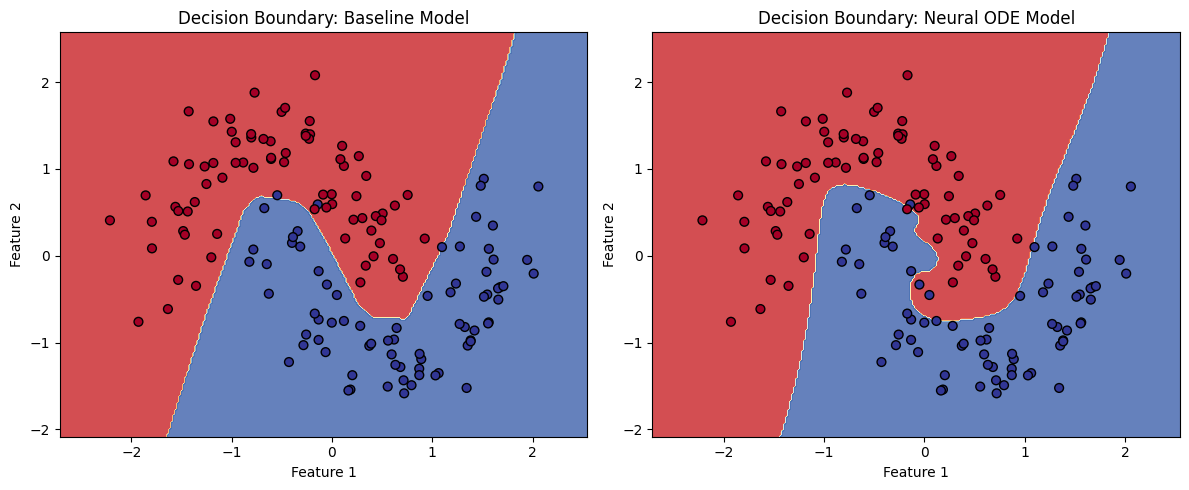

In [14]:

# (c) Visualize decision boundaries
def plot_decision_boundary(model, X, y, title):
    # This function now expects the model to be on the correct device (e.g., GPU)
    # and the data X, y to be numpy arrays on the CPU.
    
    # Create the grid for plotting
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # This grid tensor will be moved to the model's device
    # We find out the model's device by checking one of its parameters.
    model_device = next(model.parameters()).device
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(model_device)
    
    model.eval()
    with torch.no_grad():
        # The model and grid_tensor are now on the same device
        Z = model(grid_tensor)
        
        # Move the results back to CPU for numpy and plotting
        Z = torch.argmax(Z, axis=1).cpu().numpy()
        Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolors='k', cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plotting
plt.figure(figsize=(12, 5))

# Plot for the baseline model
plt.subplot(1, 2, 1)
# Pass the model as is (it's on the GPU).
# The plotting data (X_test, y_test) must be numpy arrays on the CPU.
plot_decision_boundary(baseline_model, X_test.cpu().numpy(), y_test.cpu().numpy(), "Decision Boundary: Baseline Model")

# Plot for the Neural ODE model
plt.subplot(1, 2, 2)
# Pass the model as is (it's on the GPU).
plot_decision_boundary(neural_ode_model, X_test.cpu().numpy(), y_test.cpu().numpy(), "Decision Boundary: Neural ODE Model")

plt.tight_layout()
plt.show()